# Food Delivery Time Prediction

## Objective
The goal is to predict food delivery times based on customer location, restaurant location, weather, traffic, and other factors. This involves both data preprocessing and building predictive models using linear regression and logistic regression.

## Phase 1: Data Collection and EDA


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [ ]:
DATA_PATH = "Food_Delivery_Time_Prediction.csv"

def load_data(path):
    print("Loading data...")
    df = pd.read_csv(path)
    if 'Order_ID' in df.columns:
        print("Dropping Order_ID column")
        df = df.drop(columns=['Order_ID'])
    return df

df = load_data(DATA_PATH)
df.head()

Loading data...
Dropping Order_ID column


,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


## Feature Engineering
We will calculate the Haversine distance between customer and restaurant coordinates and create a 'Is_Rush_Hour' feature.

In [ ]:
def parse_coordinates(coord_str):
    try:
        if isinstance(coord_str, str):
            coord_str = coord_str.strip('()')
            parts = coord_str.split(',')
            return float(parts[0]), float(parts[1])
        return np.nan, np.nan
    except:
        return np.nan, np.nan

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

def feature_engineering(df):
    print("Feature Engineering...")
    cust_coords = df['Customer_Location'].apply(parse_coordinates)
    rest_coords = df['Restaurant_Location'].apply(parse_coordinates)

    df['Cust_Lat'] = cust_coords.apply(lambda x: x[0])
    df['Cust_Long'] = cust_coords.apply(lambda x: x[1])
    df['Rest_Lat'] = rest_coords.apply(lambda x: x[0])
    df['Rest_Long'] = rest_coords.apply(lambda x: x[1])

    df['Calculated_Distance_km'] = haversine(df['Cust_Lat'], df['Cust_Long'], df['Rest_Lat'], df['Rest_Long'])

    print("Dropping original location columns")
    df = df.drop(columns=['Customer_Location', 'Restaurant_Location'])

    rush_hours = ['Evening', 'Afternoon']
    df['Is_Rush_Hour'] = df['Order_Time'].apply(lambda x: 1 if x in rush_hours else 0)

    return df

df = feature_engineering(df)
df.head()

Feature Engineering...
Dropping original location columns


,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Cust_Lat,Cust_Long,Rest_Lat,Rest_Long,Calculated_Distance_km,Is_Rush_Hour
0,1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54,17.030479,79.743077,12.358515,85.100083,775.651198,1
1,21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02,15.398319,86.639122,14.174874,77.025606,1042.385597,0
2,6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17,15.687342,83.888808,19.594748,82.048482,476.220706,0
3,13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23,20.415599,78.046984,16.915906,78.278698,389.912629,1
4,6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34,14.786904,78.706532,15.206038,86.203182,806.505886,0


## Data Cleaning
Handling missing values and enforcing numeric types.

In [ ]:
def clean_data(df):
    print("Cleaning data...")
    # Explicitly force numeric columns
    numeric_features = ['Distance', 'Delivery_Person_Experience', 'Restaurant_Rating', 'Customer_Rating', 'Delivery_Time', 'Order_Cost', 'Tip_Amount']
    for col in numeric_features:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Handle missing values
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().any():
            mode_val = df[col].mode()
            if not mode_val.empty:
               df[col] = df[col].fillna(mode_val[0])
            else:
               df[col] = df[col].fillna("Unknown")

    print("Missing values after cleaning:\n", df.isnull().sum())
    return df

df = clean_data(df)

Cleaning data...
Missing values after cleaning:
 Distance                      0
Weather_Conditions            0
Traffic_Conditions            0
Delivery_Person_Experience    0
Order_Priority                0
Order_Time                    0
Vehicle_Type                  0
Restaurant_Rating             0
Customer_Rating               0
Delivery_Time                 0
Order_Cost                    0
Tip_Amount                    0
Cust_Lat                      0
Cust_Long                     0
Rest_Lat                      0
Rest_Long                     0
Calculated_Distance_km        0
Is_Rush_Hour                  0
dtype: int64


## Exploratory Data Analysis (EDA)

Performing EDA...
         Distance  Delivery_Person_Experience  Restaurant_Rating  \
count  200.000000                  200.000000         200.000000   
mean    11.498050                    5.250000           3.738500   
std      6.841755                    2.745027           0.703021   
min      0.520000                    1.000000           2.500000   
25%      6.090000                    3.000000           3.200000   
50%     10.265000                    5.000000           3.800000   
75%     16.497500                    8.000000           4.300000   
max     24.900000                   10.000000           5.000000   

       Customer_Rating  Delivery_Time   Order_Cost  Tip_Amount    Cust_Lat  \
count       200.000000     200.000000   200.000000  200.000000  200.000000   
mean          3.686500      70.494950  1046.488700   46.616650   16.997762   
std           0.697063      29.830694   548.568922   29.361706    3.097039   
min           2.600000      15.230000   122.300000    1.2

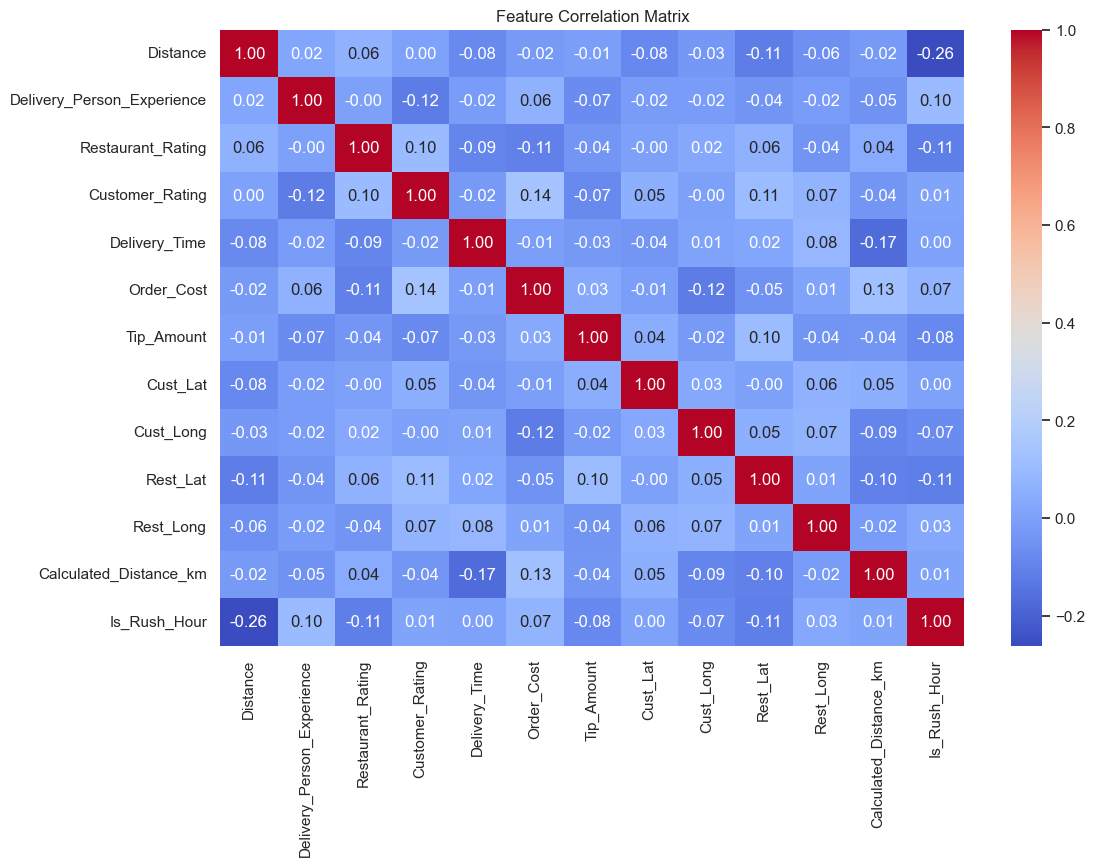

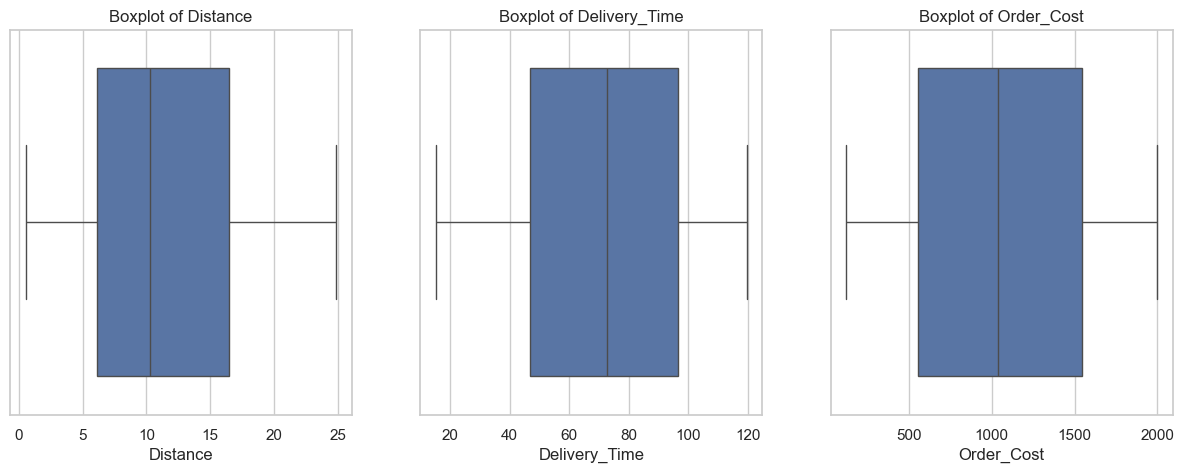

In [ ]:
def perform_eda(df):
    print("Performing EDA...")
    print(df.describe())

    plt.figure(figsize=(12, 8))
    numeric_df = df.select_dtypes(include=[np.number])
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Feature Correlation Matrix")
    plt.show()

    features_to_check = ['Distance', 'Delivery_Time', 'Order_Cost']
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(features_to_check):
        plt.subplot(1, 3, i+1)
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot of {col}")
    plt.show()

perform_eda(df)

## Phase 2: Predictive Modeling
Preprocessing data (Encoding and Scaling) and training models.

In [ ]:
def preprocess_for_modeling(df):
    print("Preprocessing for Modeling...")

    drop_cols = ['Order_ID', 'Customer_Location', 'Restaurant_Location', 'Cust_Lat', 'Cust_Long', 'Rest_Lat', 'Rest_Long']
    cols_to_drop = [c for c in drop_cols if c in df.columns]
    if cols_to_drop:
        df_model = df.drop(columns=cols_to_drop)
    else:
        df_model = df.copy()

    encoder = LabelEncoder()
    categorical_cols = df_model.select_dtypes(include=['object']).columns

    for col in categorical_cols:
        df_model[col] = encoder.fit_transform(df_model[col].astype(str))

    scaler = StandardScaler()
    target = 'Delivery_Time'
    features = [c for c in df_model.columns if c != target and c != 'Delivery_Class']

    df_model[features] = scaler.fit_transform(df_model[features])

    return df_model

df_model = preprocess_for_modeling(df)

Preprocessing for Modeling...


### Linear Regression
Predicting Delivery Time.

In [ ]:
def train_linear_regression(df):
    print("Training Linear Regression...")
    X = df.drop('Delivery_Time', axis=1)
    y = df['Delivery_Time']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Linear Regression Results:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2: {r2:.2f}")

    return model

model_lr = train_linear_regression(df_model)

Training Linear Regression...
Linear Regression Results:
MSE: 895.20
MAE: 25.82
R2: 0.03


### Logistic Regression
Classifying 'Fast' vs 'Delayed'.

Training Logistic Regression...
Median Delivery Time for classification threshold: 72.775
Logistic Regression Results:
Accuracy: 0.53
Precision: 0.55
Recall: 0.57
F1 Score: 0.56


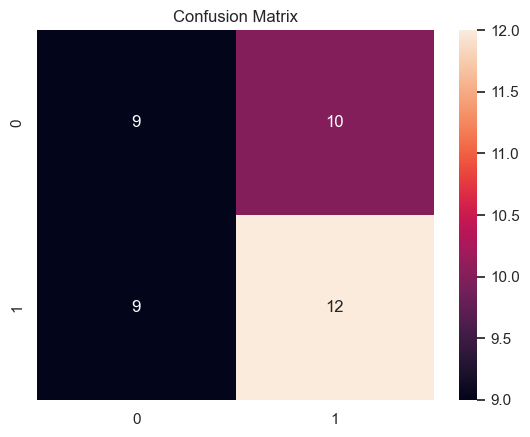

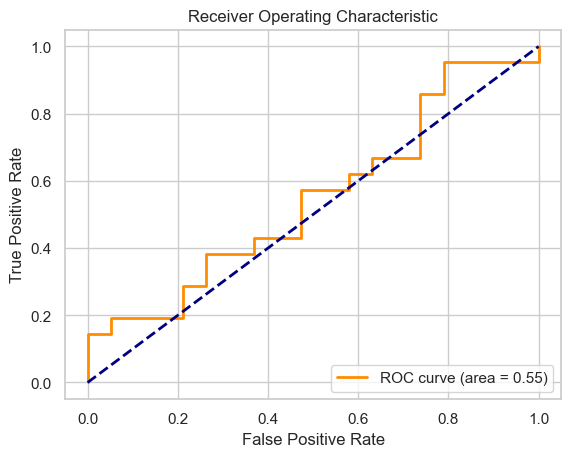

In [ ]:
def train_logistic_regression(df):
    print("Training Logistic Regression...")
    median_time = df['Delivery_Time'].median()
    print(f"Median Delivery Time for classification threshold: {median_time}")

    # Create binary target
    df = df.copy()
    df['Delivery_Class'] = (df['Delivery_Time'] > median_time).astype(int)

    X = df.drop(['Delivery_Time', 'Delivery_Class'], axis=1)
    y = df['Delivery_Class']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("Logistic Regression Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

train_logistic_regression(df_model)